In [1]:
import os
from methods.preprocessing import *
from methods.image_enhancement import *
from methods.ml import *
from methods.cnn import *

# 1. Preprocessing and EDA (Exploratory Data Analysis)

In [2]:
train_dir = "../data/fer-2013-data/train"
for dirpath,dirname,filenames in os.walk(train_dir):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath[22:]}")

There are 7 directories and 0 images in train
There are 0 directories and 3995 images in train\angry
There are 0 directories and 436 images in train\disgust
There are 0 directories and 4097 images in train\fear
There are 0 directories and 7215 images in train\happy
There are 0 directories and 4965 images in train\neutral
There are 0 directories and 4830 images in train\sad
There are 0 directories and 3171 images in train\surprise


In [3]:
data_gen = create_data_gen()
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.


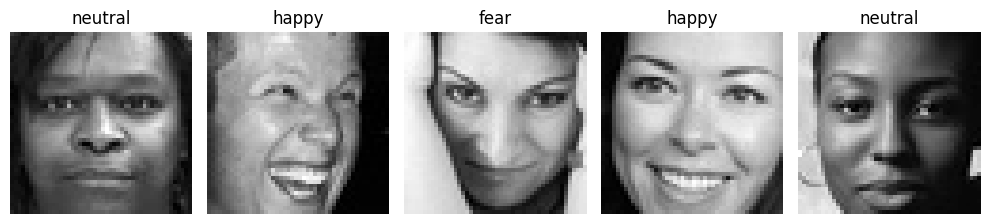

In [4]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())

images, labels = next(train_generator)
plot_example_images(images[:5], labels[:5], label_map)

# 2. Traditional Image Processing/Enhancement

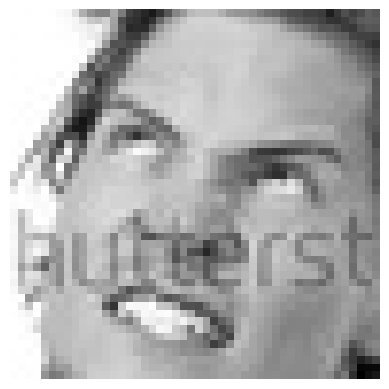

In [5]:
# this is an example image to show our enhancements on images
#improvable_image_path = "../data/fer-2013-data/train/angry/Training_2861857.jpg"
improvable_image_path = "../data/fer-2013-data/train/angry/Training_6640570.jpg"
show_image_as_plot(image_path=improvable_image_path)

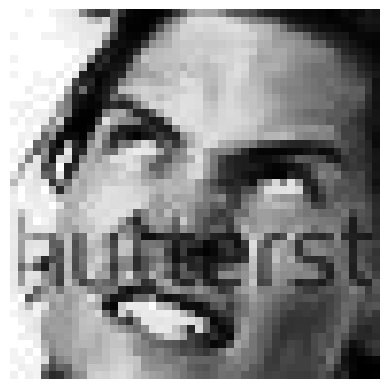

In [7]:
hist_equalized_image = histogram_equalization(image_path=improvable_image_path)
show_image_as_plot(image=hist_equalized_image)

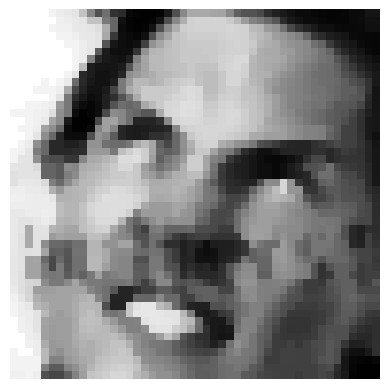

In [14]:
median_blur_image = reduce_noise_median(image=hist_equalized_image)
show_image_as_plot(image=median_blur_image)

# 3. Feature Matching

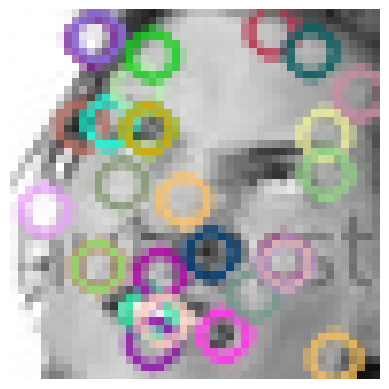

In [6]:
sift_img, _= sift_creator(image_path=improvable_image_path)
show_image_as_plot(image=sift_img)

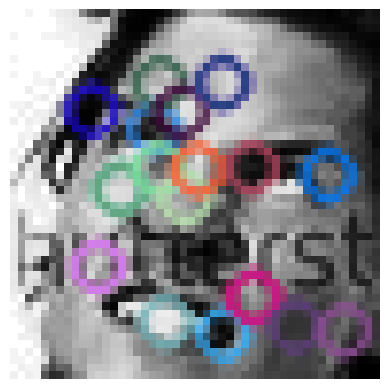

In [15]:
sift_img, _= sift_creator(image=hist_equalized_image)
show_image_as_plot(image=sift_img)

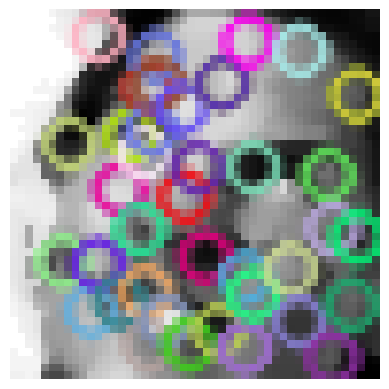

In [16]:
sift_img, _= sift_creator(image=median_blur_image)
show_image_as_plot(image=sift_img)

# 4. ML Models

In [ ]:
images_train, labels_train = load_dataset(train_dir)
features_train = extract_features(images_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)
y_train = np.array(labels_train)